# Testing the Bootstrap

Bootstrap the confidence intervals for regression coefficients and compare to the intervals found using formulas.

In [1]:
import functools
import itertools
from matplotlib import pyplot as plt 
import numpy
import pandas
import random
import seaborn
from sklearn.linear_model import LinearRegression
import statsmodels.api as stats_api

In [2]:
seaborn.set(font_scale=2.5)
seaborn.set_style("whitegrid")

In [3]:
path = '~/Documents/github/regression_strategies/CCPP/Folds5x2_pp.xlsx'
df = pandas.read_excel(path, sheet_name='Sheet1')

In [4]:
def run_min_max_scaling(cols, data):
    
    for c in cols:
        vals_ = data[c].values
        mean_ = numpy.mean(vals_)
        stddev_ = numpy.std(vals_)
    
        data[c] = (vals_ - mean_) / stddev_
    
    return data


df = run_min_max_scaling(data=df, cols=['AT', 'V', 'AP', 'RH'])

In [5]:
df["Intercept"] = 1
df.head(10)

,AT,V,AP,RH,PE,Intercept
0,-0.629519,-0.987297,1.820488,-0.009519,463.26,1
1,0.741909,0.681045,1.141863,-0.974621,444.37,1
2,-1.951297,-1.173018,-0.185078,1.289840,488.56,1
3,0.162205,0.237203,-0.508393,0.228160,446.48,1
4,-1.185069,-1.322539,-0.678470,1.596699,473.90,1
5,0.888177,0.404037,-0.173290,-0.995854,443.67,1
6,-0.504722,-0.814167,0.128134,0.132266,467.35,1
7,-1.364884,-0.755145,0.986941,-0.471179,478.42,1
8,-0.672460,-0.732324,1.434867,-2.195895,475.98,1
9,-1.061613,-0.845645,0.316735,-0.177333,477.50,1


In [6]:
X = df.drop(columns=['PE'])
y = df['PE'].values

In [7]:
mod = stats_api.OLS(y, X)
lm = mod.fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Tue, 24 Sep 2019   Prob (F-statistic):               0.00
Time:                        20:14:08   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AT           -14.7366      0.114   -129.342      0.0

In [8]:
coef_dict = {
    "Name": ["AT", "V", "AP", "RH", "Intercept"],
    "Coefficient": [-14.7366, -2.9724, 0.3687, -2.3075, 454.3650],
    "StdError": [0.114, 0.093, 0.056, 0.061, 0.047]
}

coef_df = pandas.DataFrame(coef_dict)

coef_df["TrueLowerBound"] = coef_df["Coefficient"] - 1.96 * coef_df["StdError"]
coef_df["TrueUpperBound"] = coef_df["Coefficient"] + 1.96 * coef_df["StdError"]

In [9]:
y_pred = lm.predict(X)
residuals = y - y_pred

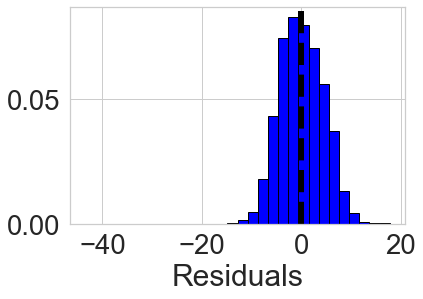

In [10]:
plt.hist(residuals, density=True, bins=30, color='blue', edgecolor='black')
plt.axvline(x=numpy.mean(residuals), linestyle='dashed', linewidth=6, color='black')
plt.xlabel('Residuals')
plt.ylabel('')
plt.show()

In [11]:
def run_boot(i, X, y, res):
    
    y_new = y + random.choices(res, k=len(res))
    
    lm = LinearRegression(fit_intercept=False, normalize=False)
    lm.fit(X, y_new)
    
    return lm.coef_.tolist()


num_boot = 5000
list_coefs = list(map(functools.partial(run_boot, X=X, y=y, res=residuals), range(num_boot)))
coefs_distribution = pandas.DataFrame(list_coefs, columns=["AT", "V", "AP", "RH", "Intercept"])
coefs_quantile = coefs_distribution.quantile(q=[0.025, 0.975], axis=0).transpose()

In [12]:
coef_df["BootLowerBound"] = coefs_quantile.loc[:, 0.025].values
coef_df["BootUpperBound"] = coefs_quantile.loc[:, 0.975].values
coef_df

,Name,Coefficient,StdError,TrueLowerBound,TrueUpperBound,BootLowerBound,BootUpperBound
0,AT,-14.7366,0.114,-14.96004,-14.51316,-14.953414,-14.504946
1,V,-2.9724,0.093,-3.15468,-2.79012,-3.155994,-2.795789
2,AP,0.3687,0.056,0.25894,0.47846,0.259106,0.480602
3,RH,-2.3075,0.061,-2.42706,-2.18794,-2.424657,-2.187736
4,Intercept,454.3650,0.047,454.27288,454.45712,454.273366,454.456304


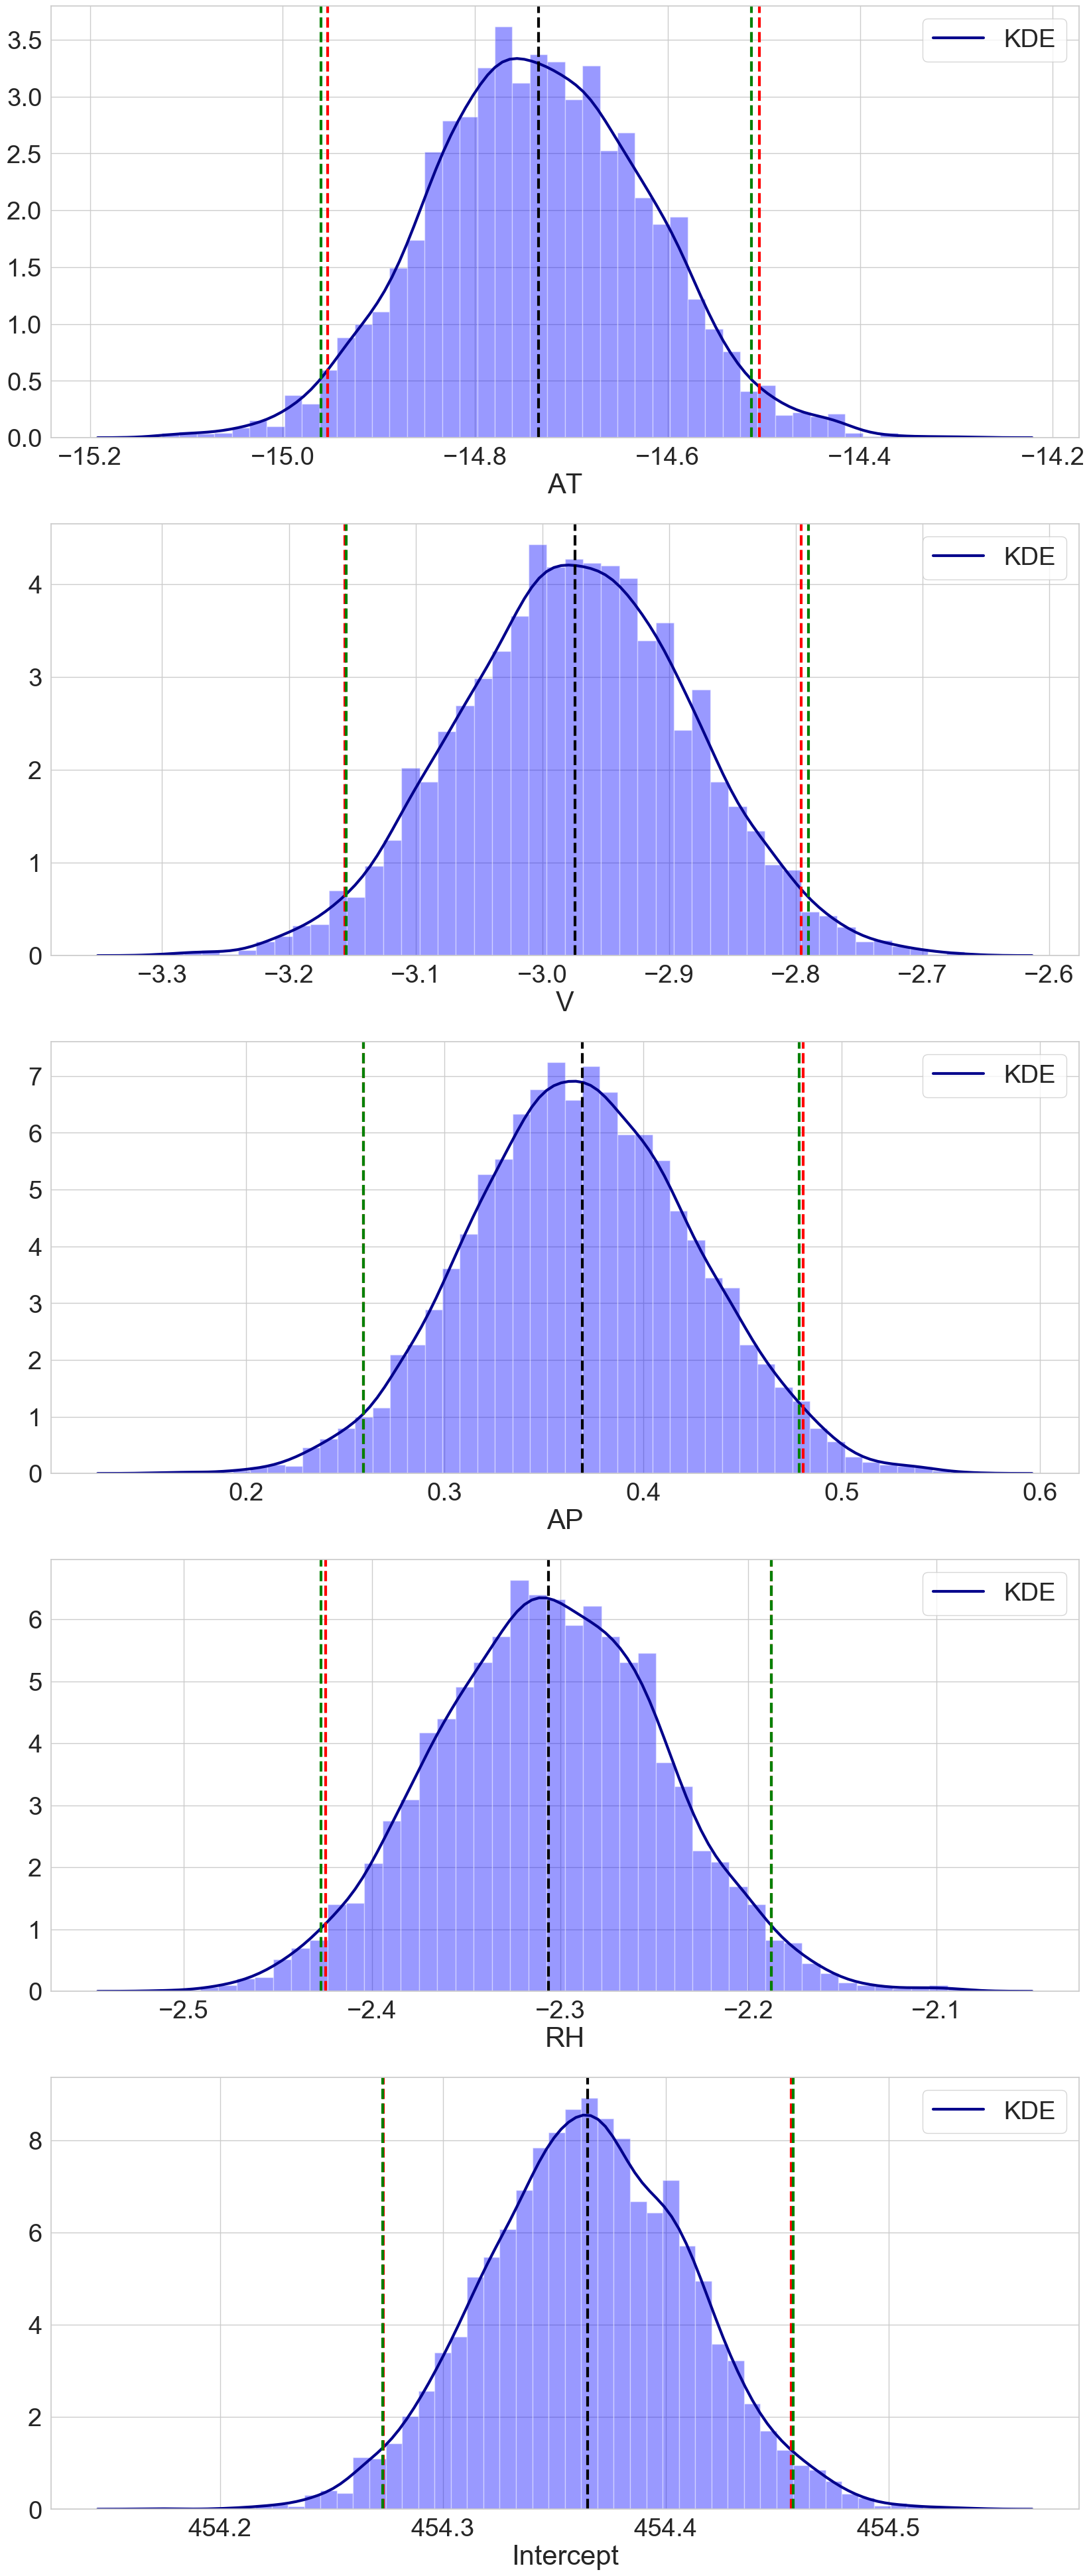

In [13]:
fig, axes = plt.subplots(5, 1, figsize=(20, 50), dpi=100)

for idx, col in enumerate(["AT", "V", "AP", "RH", "Intercept"]):
    
    seaborn.distplot(
        coefs_distribution[col], color="blue", ax=axes[idx], 
        kde_kws={"color": "darkblue", "lw": 3, "label": "KDE"}, axlabel=col
    )
    
    axes[idx].axvline(
        x=numpy.mean(coefs_distribution[col].values), 
        color="black", linestyle='--', linewidth=3
    )
    
    axes[idx].axvline(
        x=coef_df.loc[coef_df["Name"] == col, "BootLowerBound"].values[0], 
        color="red", linestyle='--', linewidth=3
    )
    axes[idx].axvline(
        x=coef_df.loc[coef_df["Name"] == col, "BootUpperBound"].values[0], 
        color="red", linestyle='--', linewidth=3
    )
    
    axes[idx].axvline(
        x=coef_df.loc[coef_df["Name"] == col, "TrueLowerBound"].values[0], 
        color="green", linestyle='--', linewidth=3
    )
    axes[idx].axvline(
        x=coef_df.loc[coef_df["Name"] == col, "TrueUpperBound"].values[0], 
        color="green", linestyle='--', linewidth=3
    )